
# Look at association of genetic status @ session 1

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import nilearn as nil
import seaborn as sns
import nibabel as nib
from scipy import io as sio
import statsmodels.api as sm
from nilearn import plotting as nlp
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from statsmodels.sandbox.stats import multicomp as smi

/home/surchs/Venv/py35/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
%matplotlib inline

In [3]:
# Paths
model_path = '/data1/guilimin/simons_vip/pheno/dataset_16p_session1.csv'
weights_path = '/data1/guilimin/simons_vip/subtype/subtypes3_16p_session1/subtype_weights.mat'
sbt_map_temp= '/data1/guilimin/simons_vip/subtype/subtypes3_16p_session1/network_{}/mean_subtype.nii.gz'

In [4]:
model = pd.read_csv(model_path, delimiter=',')

In [5]:
tmp = sio.loadmat(weights_path)
weights = tmp['weight_mat']

In [6]:
n_sbt, n_net = weights.shape[1:]

In [7]:
p_mat = np.zeros((n_sbt, n_net))
res_list = list()
for nid in range(n_net):
    tmp_list = list()
    for sid in range(n_sbt):
        m = sm.OLS(weights[:, sid, nid], model[['g1','g2','g3']])
        res = m.fit()
        p_mat[sid, nid] = res.f_pvalue
        tmp_list.append(res)
    res_list.append(tmp_list)

In [8]:
pcorr_vec = smi.multipletests(p_mat.flatten(), alpha=0.05, method='fdr_bh')
pcorr_mat = np.reshape(pcorr_vec[0], (n_sbt, n_net))

In [9]:
pcorr_mat

array([[False, False, False, False, False, False, False, False, False,
        False, False, False],
       [False, False, False, False, False, False,  True, False, False,
        False, False, False],
       [False, False, False, False, False, False,  True, False, False,
        False,  True, False]], dtype=bool)

In [11]:
# Run post hoc tests on the subtypes that show effects
hits = np.argwhere(pcorr_mat)
n_hits = len(hits)

In [12]:
# Sort hits by network
ind = np.argsort([x[1] for x in hits])
hits = hits[ind]

In [13]:
# Define the post hocs to run
post_hocs = 'g1 = g2, g2 = g3, g1 = g3'
post_dict = {0:'g1vg2', 1:'g2vg3', 2:'g1vg3'}
post_list = list()

#for hit_sbt, hit_net in hits:
for hit_sbt, hit_net in hits:
    res = res_list[hit_net][hit_sbt]
    pvals = res.t_test(post_hocs).pvalue
    # FDR
    corr = smi.multipletests(pvals, alpha=0.05, method='fdr_bh')
    # Store
    post_list.append(corr)

- G1 - Dels (Autism)
- G2 - Controls
- G3 - Dups (Schizo)

In [14]:
# Provide a summary
n_plot = 0
plot_list = list()
for pid, post in enumerate(post_list):
    sbt, net = hits[pid]
    fdr = post[0]
    pval = post[1]
    # Find fdr passing
    fdr_pass = np.argwhere(fdr)
    if fdr_pass.size == 0:
        # Nothing passed FDR, shouldn't happen?
        print('Net {} Sub {}: Nothing passed FDR\n'.format(net+1, sbt+1))
        continue
    
    matches = [x[0] for x in fdr_pass]
    for match in matches:
        print('Net {} Sub {}: {} sig (p={:.4f}) \n'.format(net+1, sbt+1, post_dict[match], pval[match]))
        n_plot += 1
        plot_list.append((net, sbt, match, pval[match]))

Net 7 Sub 2: g1vg2 sig (p=0.0001) 

Net 7 Sub 2: g2vg3 sig (p=0.0355) 

Net 7 Sub 3: g1vg2 sig (p=0.0231) 

Net 7 Sub 3: g2vg3 sig (p=0.0156) 

Net 11 Sub 3: g1vg2 sig (p=0.0005) 

Net 11 Sub 3: g1vg3 sig (p=0.0491) 



In [17]:
model.genetic

0                  deletion
1                  deletion
2               duplication
3               duplication
4                  deletion
5                  deletion
6               duplication
7               duplication
8               duplication
9                  deletion
10              duplication
11              duplication
12              duplication
13                 deletion
14              duplication
15              duplication
16                 deletion
17                 deletion
18                 deletion
19                 deletion
20                 deletion
21     non-familial0control
22     non-familial0control
23     non-familial0control
24     non-familial0control
25              duplication
26              duplication
27              duplication
28     non-familial0control
29                 deletion
               ...         
84     non-familial0control
85     non-familial0control
86     non-familial0control
87     non-familial0control
88              dupl

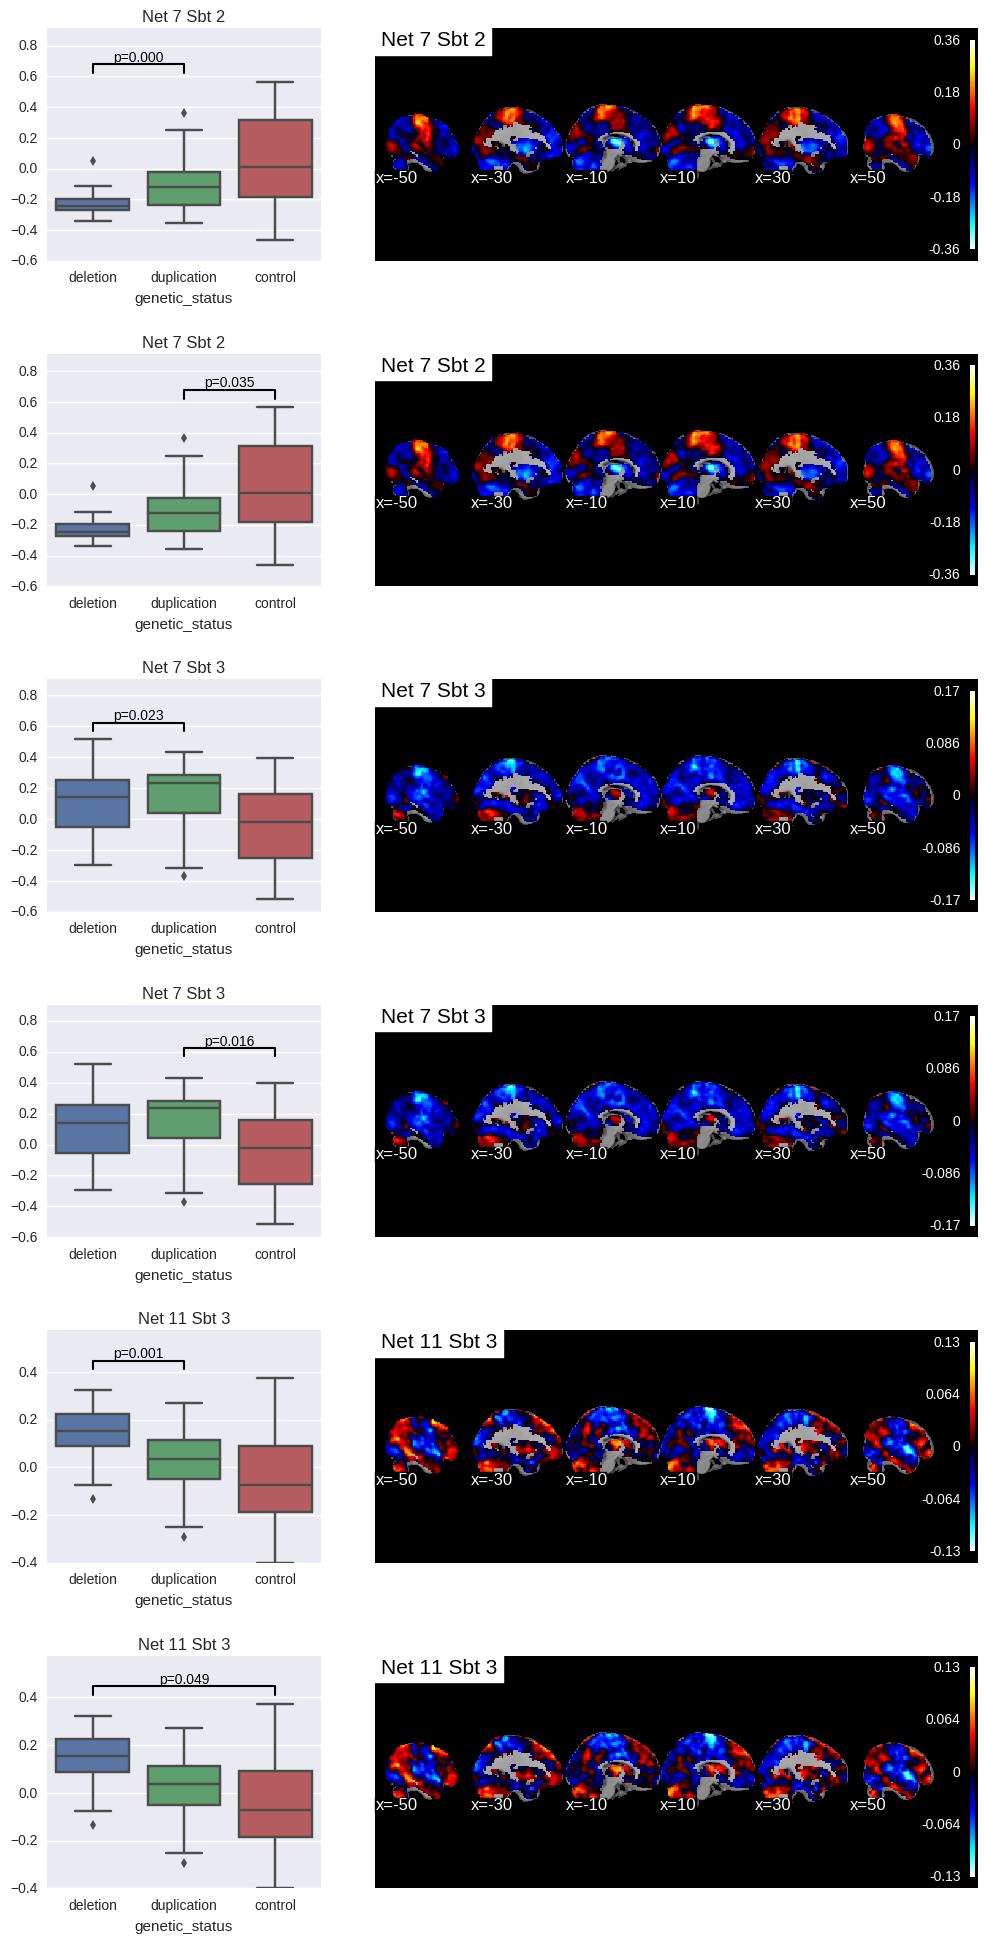

In [15]:
col = 'k'

# Plot these
fig = plt.figure(figsize=(12,4*n_plot))
gs = gridspec.GridSpec(n_plot, 3, hspace=0.4)
for pid, plot in enumerate(plot_list):
    net, sbt, match, pval = plot
    ax = fig.add_subplot(gs[pid,0])
    
    if match == 0:
        x1, x2 = 0, 1
    elif match == 1:
        x1, x2 = 1, 2
    elif match == 2:
        x1, x2 = 0, 2

    y = weights[:, sbt, net].max()
    h = y*0.1
    y += y*0.1
    
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    ax.text((x1+x2)*.5, y+h, 'p={:.3f}'.format(pval), ha='center', va='bottom', color=col)
    sns.boxplot(model.genetic_status, weights[:, sbt, net], ax=ax)
    (dn, up) = ax.get_ylim()
    ax.set_ylim((dn, up+2*h))
    ax.set_title('Net {} Sbt {}'.format(net+1, sbt+1))
    
    ax2 = fig.add_subplot(gs[pid,1:])
    tmp_i = nib.load(sbt_map_temp.format(net+1))
    # Load the corresponding network
    nlp.plot_stat_map(nil.image.index_img(tmp_i, sbt), display_mode='x', threshold=0, 
                      cut_coords=[-50, -30, -10, 10, 30, 50], black_bg=True,axes=ax2,
                      title='Net {} Sbt {}'.format(net+1, sbt+1))

In [16]:
n_hits

3